<a href="https://colab.research.google.com/github/WalterPHD/Ai-Data/blob/main/Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem 1

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
df = pd.read_csv(os.path.join(csv_path, 'jena_climate_2009_2016.csv'))

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


In [7]:
TRAIN_SPLIT = 300000

In [8]:
tf.random.set_seed(13)


In [9]:

uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

,T (degC)
Date Time,
01.01.2009 00:10:00,-8.02
01.01.2009 00:20:00,-8.41
01.01.2009 00:30:00,-8.51
01.01.2009 00:40:00,-8.31
01.01.2009 00:50:00,-8.27


array([<Axes: xlabel='Date Time'>], dtype=object)

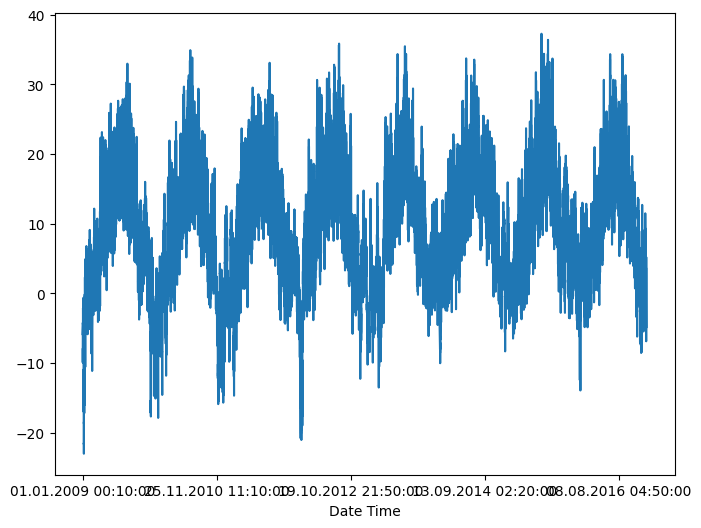

In [10]:
uni_data.plot(subplots=True)

Problem 2

In [11]:
uni_data = uni_data.values


In [12]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [13]:

uni_data = (uni_data-uni_train_mean)/uni_train_std

In [14]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,univariate_past_history,univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,univariate_past_history,univariate_future_target)

In [15]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [16]:

def create_time_steps(length):
  return list(range(-length, 0))

In [17]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

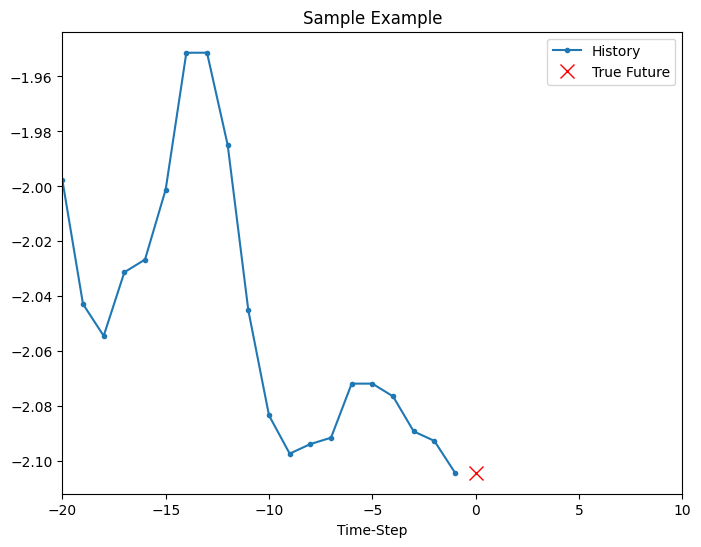

In [18]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [19]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

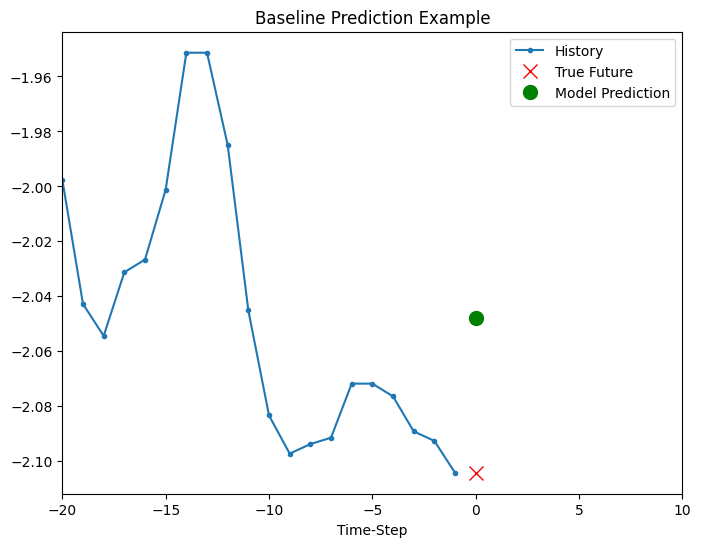

In [20]:

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,'Baseline Prediction Example')


In [21]:

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [22]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
(256, 1)


In [24]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.5620 - val_loss: 0.0683
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0835 - val_loss: 0.0300
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0407 - val_loss: 0.0237
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0396 - val_loss: 0.0227
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0242 - val_loss: 0.0213
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0263 - val_loss: 0.0206
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0292 - val_loss: 0.0202
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0273 - val_loss: 0.0190
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0257 - val_loss: 0.0184
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0244 - val_loss: 0.0180


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


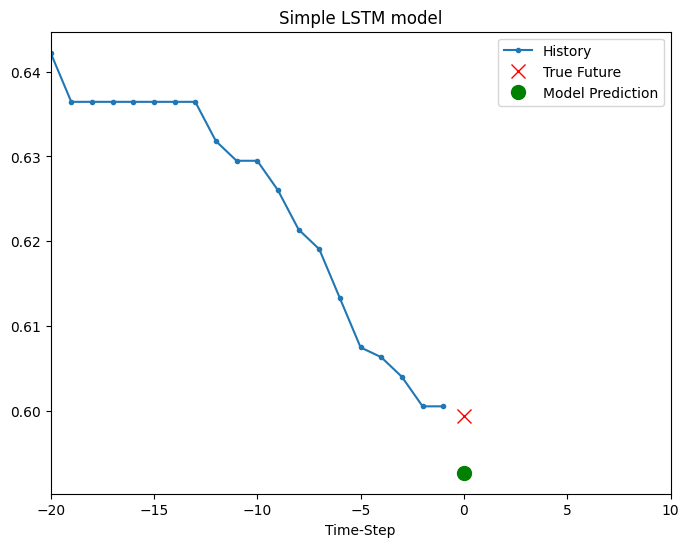

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


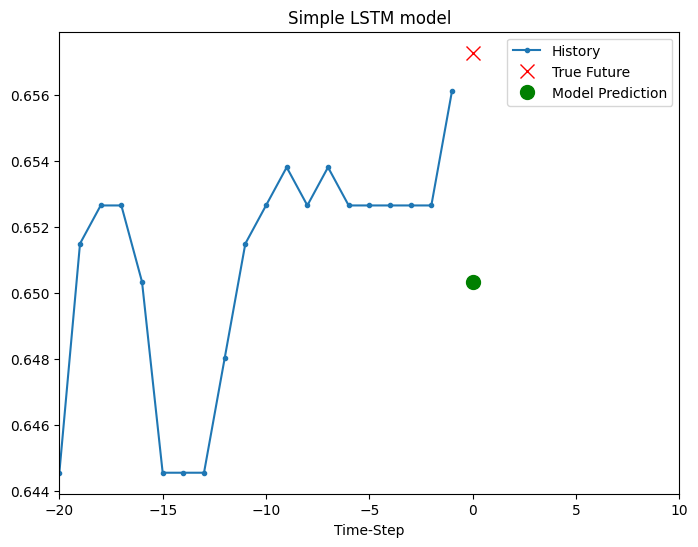

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


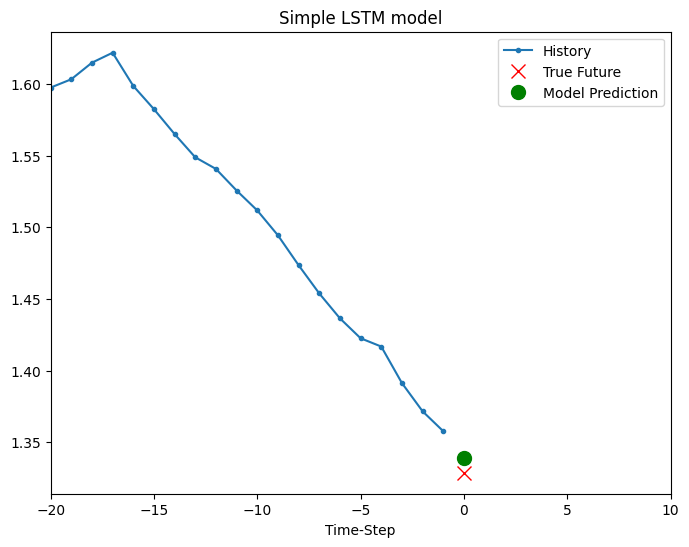

In [25]:

for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [26]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [27]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

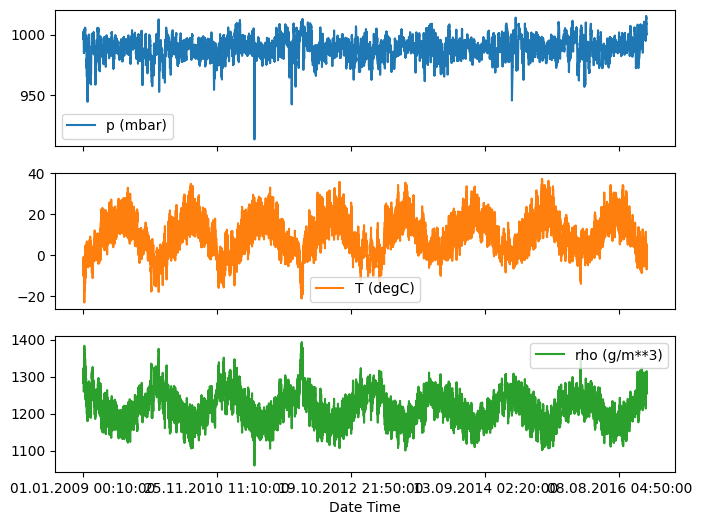

In [28]:

features.plot(subplots=True)


In [29]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)


In [30]:
dataset = (dataset-data_mean)/data_std

In [31]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [32]:

past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,TRAIN_SPLIT, past_history,future_target, STEP,single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],TRAIN_SPLIT, None, past_history,future_target, STEP,single_step=True)

In [33]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [34]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()


In [35]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(256, 1)


In [37]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_single,validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - loss: 0.4065 - val_loss: 0.2577
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - loss: 0.2712 - val_loss: 0.2416
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - loss: 0.2706 - val_loss: 0.2460
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - loss: 0.2678 - val_loss: 0.2386
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 0.2218 - val_loss: 0.2356
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - loss: 0.2448 - val_loss: 0.2554
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 0.2448 - val_loss: 0.2600
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - loss: 0.2441 - val_loss: 0.2598
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - loss: 0.2531 - val_loss: 0.2491
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - loss: 0.2570 - val_loss: 0.2346


In [38]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

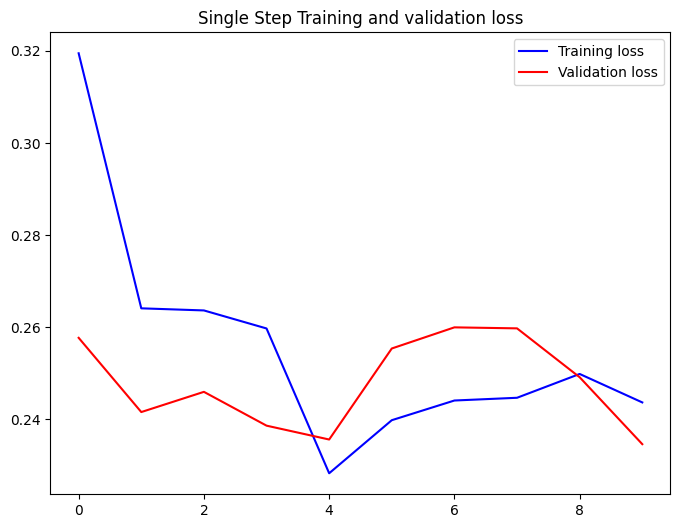

In [39]:

plot_train_history(single_step_history,'Single Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


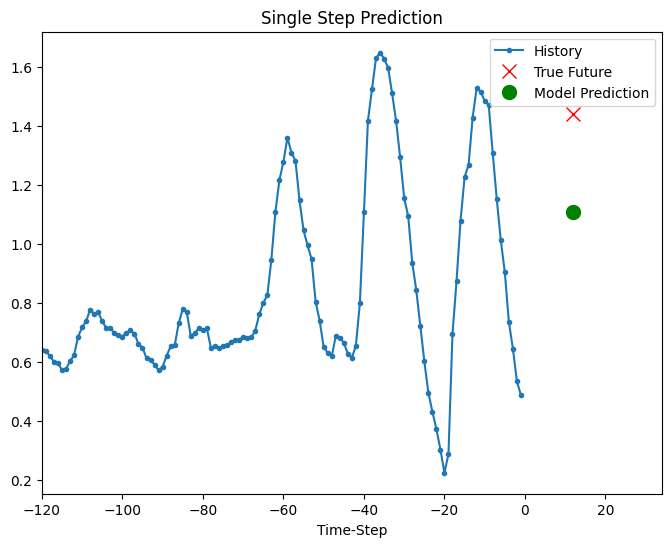

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


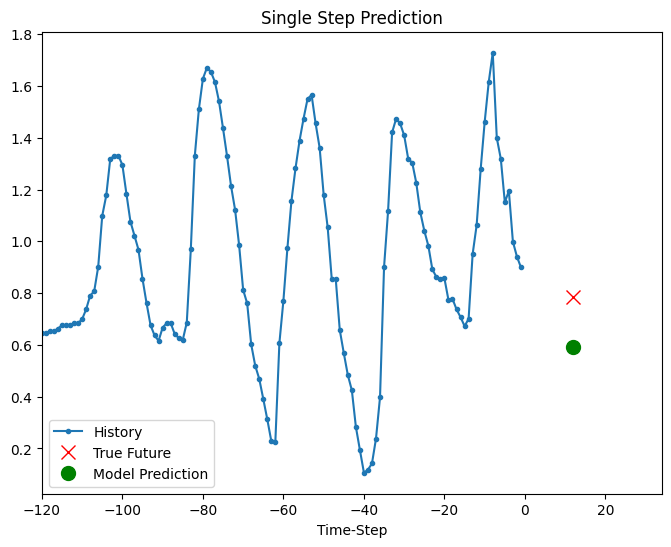

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


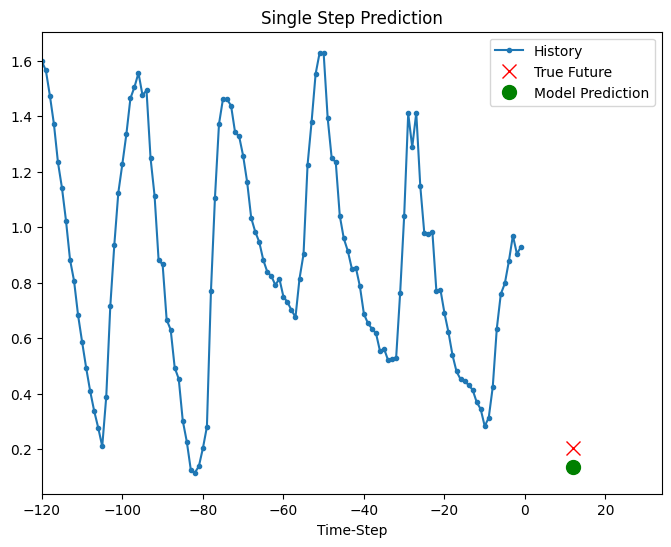

In [40]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),single_step_model.predict(x)[0]], 12,'Single Step Prediction')
  plot.show()

In [41]:

future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,TRAIN_SPLIT, past_history,future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],TRAIN_SPLIT, None, past_history,future_target, STEP)

In [42]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [43]:

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [44]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()


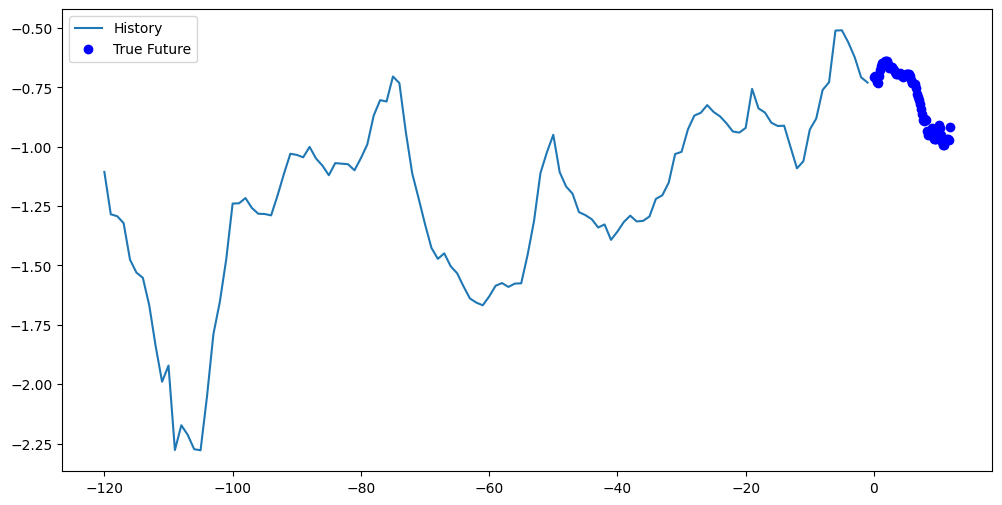

In [45]:

for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [46]:

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,return_sequences=True,input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [47]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
(256, 72)


In [48]:

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi,validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 224ms/step - loss: 0.6582 - val_loss: 0.2903
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 0.3310 - val_loss: 0.2662
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 214ms/step - loss: 0.3168 - val_loss: 0.2369
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 198ms/step - loss: 0.2497 - val_loss: 0.2138
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 407ms/step - loss: 0.1979 - val_loss: 0.2022
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - loss: 0.2123 - val_loss: 0.2208
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 412ms/step - loss: 0.2085 - val_loss: 0.2133
Epoch 8/10
 60/200 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - loss: 0.2061

KeyboardInterrupt: 

In [ ]:

plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

Problem 3

In [ ]:
import numpy as np
import pandas as pd
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.optimizers import Adam # - Works

df = pd.read_csv("Iris.csv")

df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(int)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [ ]:
K.clear_session( )

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid))

In [ ]:

model.summary()


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(loss='binary_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.01),metrics=['accuracy'])
history = model.fit(X_train, y_train,batch_size=10,epochs=10,verbose=1,callbacks=[callback],validation_data=(X_val, y_val))

In [ ]:

y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())


In [ ]:

score = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Problem 4

In [ ]:
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("Iris.csv")

y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int64)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)

In [ ]:

K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))


In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

history = model.fit(X_train, y_train_one_hot, batch_size=10, epochs=10, verbose=0, validation_data=(X_val, y_val_one_hot))

In [ ]:
y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)

print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

In [ ]:

score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Problem 5

In [ ]:
from sklearn.preprocessing import StandardScaler

train = pd.read_csv('train.csv')

x = train[['GrLivArea', 'YearBuilt']]
y = train[['SalePrice']]

x = np.log(x).values
y = np.log(y).values

sc = StandardScaler()
sc.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [ ]:
K.clear_session( )


In [ ]:

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(2,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.keras.activations.linear))

In [ ]:
model.summary()

In [ ]:

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=0.01), metrics=['mse'])
history = model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, callbacks=[callback], validation_data=(X_val, y_val))


In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba
print("y_pred", y_pred.ravel()[:5])
print('y_test', y_test.ravel()[:5])

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('loss (test):', score[0])
print('Mean Squared Error (test):', score[1])

Problem 6

In [ ]:

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
X_train /= 255
X_test /= 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [ ]:
K.clear_session( )

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(784,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.005), metrics=['accuracy'])
history = model.fit(X_train, y_train_one_hot, batch_size=20, epochs=5, verbose=1, validation_data=(X_val, y_val_one_hot))

In [ ]:

y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred", y_pred[:10])
print('y_test', y_test.ravel()[:10])


In [ ]:
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Problem 7

In [ ]:
#import data
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

In [ ]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

In [ ]:

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Problem 8

TensorFlow is a very powerful and mature deep learning library with strong visualisation capabilities and several options to use for high-level model development. It has production-ready deployment options and supports mobile platforms. TensorFlow is a good option if you :

Develop models for production use.
Develop models that are to be deployed on mobile platforms
Want good community support and comprehensive documentation
Want rich learning resources in a variety of formats (TensorFlow has a comprehensive MOOC)
Want or need to use Tensorboard
Need to use large-scale distributed model building
PyTorch is a fully featured framework for building deep learning models, which is a type of machine learning that’s commonly used in applications like image recognition and language processing. Written in Python, it’s relatively easy for most machine learning developers to learn and use. PyTorch is distinctive for its excellent support for GPUs and its use of reverse-mode auto-differentiation, which enables computation graphs to be modified on the fly. This makes it a popular choice for fast experimentation and prototyping.

Why PyTorch?

PyTorch is the work of developers at Facebook AI Research and several other labs. The framework combines the efficient and flexible GPU-accelerated backend libraries from Torch with an intuitive Python frontend that focuses on rapid prototyping, readable code, and support for the widest possible variety of deep learning models. Pytorch lets developers use the familiar imperative programming approach, but still output to graphs. It was released to open source in 2017, and its Python roots have made it a favorite with machine learning developers.

PyTorch is still a young framework that is growing rapidly. It may be suitable for you if you:

You are doing research or the non-functional requirements of your production are not very high
You want a better development and debugging experience
You like all things Python